In [59]:
import tensorflow as tf

tf.__version__

'2.0.0-beta1'

In [27]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [43]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

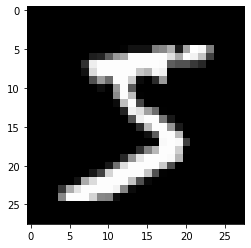

In [12]:
plt.imshow(X_train[0], cmap='gray')

In [44]:
training_img_count = len(X_train)
testing_img_count = len(X_test)

BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

def create_ds(images, labels, image_count):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))

    # Setting a shuffle buffer size as large as the dataset ensures that the data is
    # completely shuffled.
    ds = ds.shuffle(buffer_size=image_count)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetch batches in the background while the model is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [45]:
training_set = create_ds(X_train, y_train, training_img_count)
testing_set = create_ds(X_test, y_test, testing_img_count)

In [46]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.batch_val_losses = []
        self.batch_val_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
        self.model.reset_metrics()
  
    def on_test_batch_end(self, batch, logs=None):
        self.batch_val_losses.append(logs['loss'])
        self.batch_val_acc.append(logs['accuracy'])
        self.model.reset_metrics()

Image batch shape:  (64, 28, 28)
Label batch shape:  (64,)


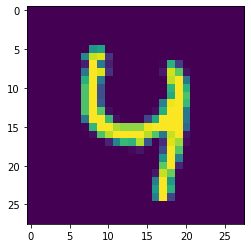

In [66]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(28,28), target_shape=(28, 28, 1)),
      
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, use_bias=False, padding='same'),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(200, use_bias=False),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization_28 (Batc (None, 28, 28, 12)        36        
_________________________________________________________________
activation_28 (Activation)   (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_29 (Batc (None, 14, 14, 24)        72        
_________________________________________________________________
activation_29 (Activation)   (None, 14, 14, 24)       

In [67]:
# lr decay function
def lr_decay(epoch):
  return 0.01 * np.power(0.666, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

In [68]:
steps_per_epoch = training_img_count // BATCH_SIZE
val_steps_per_epoch = testing_img_count // BATCH_SIZE
batch_stats_callback = CollectBatchStats()

history = model.fit(training_set, epochs=10, 
            steps_per_epoch=steps_per_epoch,
            callbacks=[lr_decay_callback],
            validation_data=testing_set,
            validation_steps=val_steps_per_epoch)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/10
937/937 [==============================] - 61s 65ms/step - loss: 0.1244 - accuracy: 0.9614 - val_loss: 0.0478 - val_accuracy: 0.9839

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00666.
Epoch 2/10
937/937 [==============================] - 59s 63ms/step - loss: 0.0472 - accuracy: 0.9856 - val_loss: 0.0370 - val_accuracy: 0.9892

Epoch 00003: LearningRateScheduler reducing learning rate to 0.004435560000000001.
Epoch 3/10
937/937 [==============================] - 54s 58ms/step - loss: 0.0297 - accuracy: 0.9907 - val_loss: 0.0242 - val_accuracy: 0.9920

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0029540829600000007.
Epoch 4/10
937/937 [==============================] - 55s 58ms/step - loss: 0.0209 - accuracy: 0.9938 - val_loss: 0.0210 - val_accuracy: 0.9944

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0019674192513600007.
Epoch 5/10
937/937 [===========

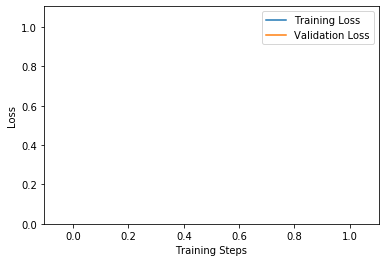

In [69]:
def plot_loss(training_losses, val_losses, x_label='Training Steps'):
    plt.figure()
    plt.ylabel("Loss")
    plt.xlabel(x_label)
    
    training_steps = len(training_losses)
    test_steps = len(val_losses)
    plt.plot(training_losses, label='Training Loss')
    plt.plot(np.linspace(0, training_steps, test_steps), val_losses, label='Validation Loss')
    plt.ylim([0,max(plt.ylim())])
    plt.legend(loc='upper right')
    plt.show()
    
plot_loss(batch_stats_callback.batch_losses, batch_stats_callback.batch_val_losses)

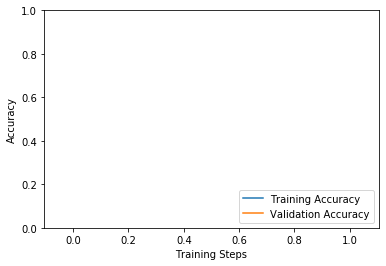

In [70]:
def plot_accuracy(training_acc, val_acc, x_label='Training Steps'):
    plt.figure()
    plt.ylabel("Accuracy")
    plt.xlabel(x_label)
    
    training_steps = len(training_acc)
    test_steps = len(val_acc)
    plt.plot(training_acc, label='Training Accuracy')
    plt.plot(np.linspace(0, training_steps, test_steps), val_acc, label='Validation Accuracy')
    plt.ylim([0,1])
    plt.legend(loc='lower right')
    plt.show()
    
plot_accuracy(batch_stats_callback.batch_acc, batch_stats_callback.batch_val_acc)

In [71]:
for image_batch, label_batch in test_set:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (64, 28, 28)
Label batch shape:  (64,)


In [73]:
# Predict
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=1)

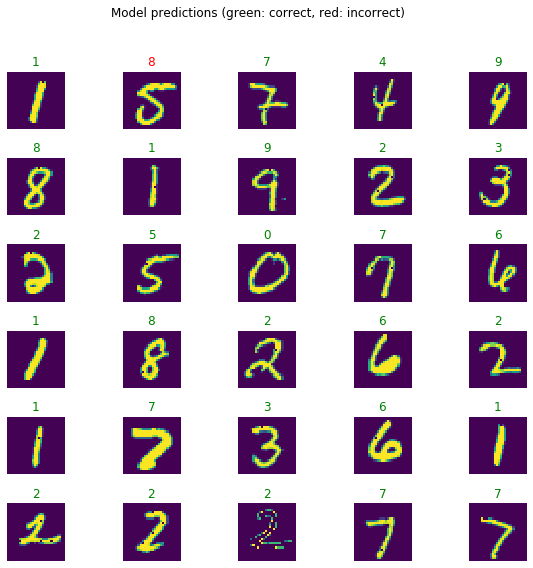

In [74]:
# Plot the result

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow((image_batch[n]+1)/2)
  color = "green" if predicted_id[n] == label_batch.numpy()[n] else "red"
  plt.title(str(predicted_id[n]), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [75]:
model.save('model.h5')

In [76]:
reloaded_model = tf.keras.models.load_model('model.h5')
reloaded_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization_28 (Batc (None, 28, 28, 12)        36        
_________________________________________________________________
activation_28 (Activation)   (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_29 (Batc (None, 14, 14, 24)        72        
_________________________________________________________________
activation_29 (Activation)   (None, 14, 14, 24)       

In [77]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded_model.predict(image_batch)

In [78]:
abs(reloaded_result_batch - result_batch).max()

0.0